### Import Libraries

In [13]:
import re
import time
import random
import imageio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.figure import Figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

### K-Means

In [14]:
class KMeans:
    def __init__(self, n_clusters=2, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centers = None
        
    def dist(self, data_points, center):
        return np.sqrt(np.sum((data_points - center) ** 2, axis=1))
        
    def fit(self, data):
        # get initial centers from the samples itself.
        # better initializations are also available - have a look at kmeans++
        self.centers = data[
            np.random.choice(np.arange(len(data)), size=self.n_clusters)
        ]
        
        # kmeans algorithm
        for _ in range(self.max_iter):
            dist_matrix = np.zeros((len(data), self.n_clusters))
            for i in  range(self.n_clusters):
                dist_matrix[:, i] = self.dist(data, self.centers[i])
            cluster_assignment = dist_matrix.argmin(axis=1)
            # find new centers
            new_centers = np.zeros_like(self.centers)
            for i in range(self.n_clusters):
                new_centers[i] = np.mean(data[cluster_assignment == i], axis=0)
            # break if we have converged
            if np.allclose(new_centers, self.centers):
                self.centers = new_centers
                break
            self.centers = new_centers
        
    def predict(self, data):
        dist_matrix = np.zeros((len(data), self.n_clusters))
        for i in range(self.n_clusters):
            dist_matrix[:, i] = self.dist(data, self.centers[i])
        cluster_assignment = dist_matrix.argmin(axis=1)
        return cluster_assignment

### GMM

In [15]:
class GMM:
    def __init__(
        self, 
        n_mixtures=2, 
        max_iter=1000, 
        covar_type='full', 
        plot_progress=True, 
        p_iter=5,
        gif_name='EM_Progress.gif'
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.plot_progress = plot_progress
        self.p_iter = p_iter
        self.gif_name = gif_name
        self.log_likelihood_plot_list = None
        
    def p(self, data, mean, cov):
        dist = multivariate_normal(mean=mean, cov=cov)
        return dist.pdf(data)
    
    def predict(self, data):
        posteriors = np.zeros((len(data), self.n_mixtures))
        for i in range(self.n_mixtures):
            posteriors[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        labels = np.argmax(posteriors, axis=1)
        return labels
    
    def full_covar(self, data, resp):
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = data - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i].flat[::data.shape[1] + 1] += 1e-6
        return new_covs
            
    def diag_covar(self, data, resp):
        sqrd_data = np.dot(resp.T, data * data) / resp.sum(axis=0)[:, None]
        sqrd_means = self.means ** 2
        means = self.means * np.dot(resp.T, data) / resp.sum(axis=0)[:, None]
        diag_covs = (sqrd_data - 2 * means + sqrd_means + 1e-6)
        new_covs = [np.diag(cov) for cov in diag_covs]
        return new_covs
    
    def e_step(self, data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        # normalize the sum
        resp = resp / resp.sum(axis=1)[:, None]
        return resp
        
    def m_step(self, data, resp):        
        # re-estimation for alphas
        new_alphas = resp.mean(axis=0)
        
        # re-estimation for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i][:, None], data).sum(axis=0) / resp[:, i].sum()
        
        # re-estimation for covariance matrix
        if self.covar_type == 'full':
            new_covs = self.full_covar(data, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(data, resp)
        else:
            raise NotImplementedError()
            
        return new_alphas, new_means, new_covs
    
    def plot_creator(self, data):
        labels = self.predict(data)
        
        # create figure
        fig = Figure(figsize=(10, 8))
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        for i in range(self.n_mixtures):
            ax.scatter(data[:,0][labels == i], data[:, 1][labels == i], s=12, label='GMM-'+str(i))
        ax.set_xlabel('PC-1')
        ax.set_ylabel('PC-2')
        ax.set_title('Progress of EM Algorithm')
        ax.legend()
        fig.dpi = 200
        canvas.draw()
        image = np.asarray(canvas.buffer_rgba())
        return image
        
        
    def fit(self, data):
        n_features = data.shape[1]
        # intialize empty lists to store images and 
        # progress of EM algorithm per step
        progress_images = []
        self.log_likelihood_plot_list = []
        
        # initialize means
        kmeans_model = KMeans(n_clusters=self.n_mixtures)
        kmeans_model.fit(data)
        self.means = kmeans_model.centers
        
        # initialize cov
        self.covs = np.zeros((self.n_mixtures, n_features, n_features))
        data_labels = kmeans_model.predict(data)
        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(data[data_labels == i].T)
        
        # EM - algorithm
        for step in range(self.max_iter):
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(data)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(data, resp)
            
            # display progress after every 5 iterations
            if step % self.p_iter == 0 and self.plot_progress:
                progress_images.append(self.plot_creator(data))
            
            # break if convergence
            if np.allclose(self.alphas, alphas, rtol=1e-3, atol=1e-3) and \
               np.allclose(self.means, means, rtol=1e-3, atol=1e-3) and \
               np.allclose(self.covs, covs, rtol=1e-3, atol=1e-3):
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]
        
        if self.plot_progress: 
            imageio.mimsave(self.gif_name, progress_images)
            

### Read the dataset

In [16]:
with open('dataset.txt', 'r') as f:
    corpus = f.read().splitlines()
labels = np.array([int(doc[-1]) for doc in corpus])
corpus = [doc[:-2].strip() for doc in corpus]

### Vocabulary Creator

In [17]:
def vocabulary_tf(corpus):
    '''
    Input
    -----
    corpus: list of reviews
    
    Returns
    -------
    vocab: set of unique words
    doc_word_count: list of shape(N,) where each element is the word count of each document
    word_doc_count: dict with words as keys and their document frequency as values
    '''
    # extract the vocabulary from the documents
    # and obtain word counts per document
    vocab = set()
    doc_word_count = []
    for doc in corpus:
        # observe we are ignoring the numbers and punctuations if any
        # this is a hyperparameter to play with and is left as an exercise
        sent = re.sub(r'[^A-Za-z]', ' ', doc).lower()
        words = sent.split()
        doc_word_count.append(dict(Counter(words)))
        vocab.update(set(words))
    vocab = list(vocab)
    # calculate document-frequency of each word in vocabulary
    word_doc_count = {word: 0 for word in vocab}
    for word in vocab:
        for doc_words in doc_word_count:
            if word in doc_words.keys():
                word_doc_count[word] += 1
    vocab.sort()
    return vocab, doc_word_count, word_doc_count

### TF-IDF Vectorizer

In [18]:
def tf_idf_vectorizer(vocab, doc_word_count, word_doc_count):
    '''
    Inputs
    ------
    vocab: set of unique words
    doc_word_count: list of shape(N,) where each element is the word count of each document
    word_doc_count: dict with words as keys and their document frequency as values
    
    Returns
    -------
    doc_vectors: 2d array of shape(N, len(vocab)) - representing tf-idf vectors
    '''
    doc_vectors = np.zeros((len(doc_word_count), len(vocab)))
    for i, doc in enumerate(doc_word_count):
        for j, word in enumerate(vocab):
            if word not in doc.keys():
                continue
            # term frequency -tf
            total_word_count_doc = sum(doc.values())
            tf = doc[word]
            # document frequency - df
            df = word_doc_count[word]
            # inverse document frequency - idf
            idf = 1 + np.log((1 + len(doc_word_count)) / (1 + df))
            doc_vectors[i, j] = tf * idf
    return doc_vectors

In [19]:
def document_vectorizer(corpus):
    vocab, doc_word_count, word_doc_count = vocabulary_tf(corpus)
    doc_vectors = tf_idf_vectorizer(vocab, doc_word_count, word_doc_count)
    return doc_vectors

In [20]:
doc_vectors_pre_pca = document_vectorizer(corpus)

doc_vectors_pre_pca.shape

(1000, 3084)

### Perform PCA

In [21]:
doc_vectors = PCA(n_components=10, whiten=True).fit_transform(doc_vectors_pre_pca)

doc_vectors.shape

(1000, 10)

### Perform GMM training

In [22]:
# because of heuristic initialization of KMeans, you might 
# have to run the code again if error is thrown related to NaNs
gif_name='em_algo_progress.gif'
model = GMM(n_mixtures=2, covar_type='diag', p_iter=1, gif_name=gif_name)
model.fit(doc_vectors)

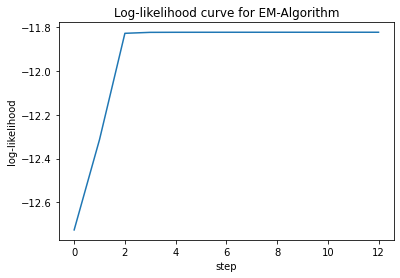

In [23]:
# obtain the log-likelihood curve to check 
# if the implementation was correct
plt.plot(model.log_likelihood_plot_list)
plt.xlabel('step')
plt.ylabel('log-likelihood')
plt.title('Log-likelihood curve for EM-Algorithm')
plt.show()

### Display the progress

In [24]:
# you would have to run the code again to generate the below plot
from IPython.display import HTML
HTML(f'<img src={gif_name}?{time.time()} width="700">')

### Scatter Plot with first two PCA dimension with actual labels

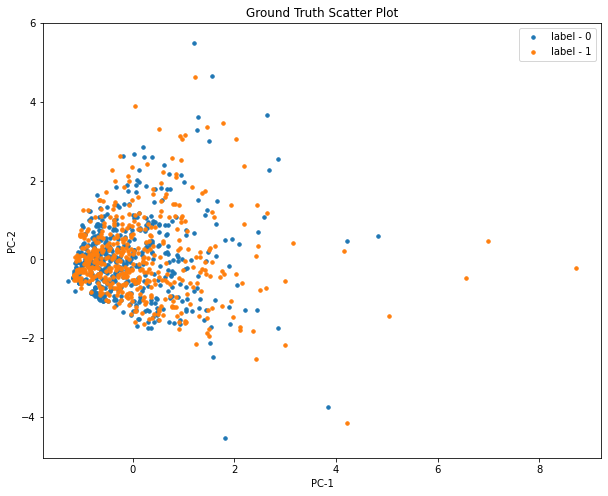

In [25]:
plt.figure(figsize=(10, 8))
for i in range(2):
    plt.scatter(doc_vectors[:, 0][labels == i], doc_vectors[:, 1][labels == i], s=12, label='label - '+str(i))
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Ground Truth Scatter Plot')
plt.legend()
plt.savefig('GT_Plot.jpeg', dpi=200)
plt.show()
plt.close()

### Observation

We notice that reviews for the two classes are quite overlapped in the latent space on which the data has been projected. Thus, it is expected that the model will not perform well if the classification is to be performed based on just the posterior probabilities of the Gaussians. This fact is quite evident from the plots shown above where we observe that the Gaussians at least in the first two dimensional space of PCA is learning to mimic the data distribution but cannot differentiate between the two.

We will now find out the confusion matrix for such a classification below.

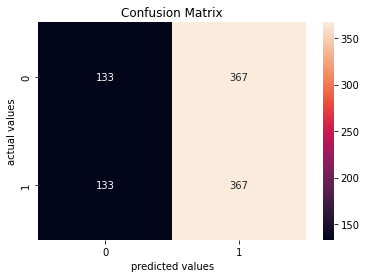

In [26]:
# obtain the labels from the GMM
pred_labels = model.predict(doc_vectors)
# get the confusion matrix
conf_mat = confusion_matrix(labels, pred_labels)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.title('Confusion Matrix')
plt.show()

Quite evidently the overlap has forced the model to learn a skewed distribution and thus there is no correlation between the predicted and the ground truth label as such.

In [27]:
# The correlation coefficient is
np.corrcoef(pred_labels.reshape(-1), labels.reshape(-1))[0, 1]

0.0